In [1]:
#训练一个图像分类器
#依次按照下列顺序进行：
#1.使用torchvision加载和归一化CIFAR10训练集和测试集
#2.定义一个卷积神经网络
#3.定义损失函数
#4.在训练集上训练网络
#5.在测试集上测试网络

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms

In [3]:
#torchvision的输出是[0,1]的PILImage图像，我们把它转换为归一化范围为[-1,1]的张量
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),
                                                   (0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                       download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,
                                         shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                      download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,
                                        shuffle=False,num_workers=2)
classes = ('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


horse  ship horse   car


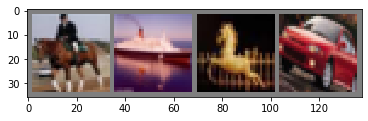

In [4]:
#展示一些训练图片
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#展示图像的函数
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

#获取随机数据
dataiter = iter(trainloader)
images,labels = dataiter.next()

#展示图像
imshow(torchvision.utils.make_grid(images))
#展示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
#定义一个神经网络
#从之前的神经网络一节复制神经网络代码，并修改为输入3通道图像
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #3个输入图像通道，6个输出通道，5x5卷积核
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)          #max pooling 2x2
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Linear(16 * 5 * 5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))        
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
#定义损失函数和优化器
#使用交叉熵作为损失函数，使用带动量的随机梯度下降
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [7]:
#训练网络
for epoch in range(2):     #多批次循环
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        #获取输入
        inputs,labels = data
        
        #梯度置0
        #梯度数值会保存，下一轮的梯度值会叠加到上轮的梯度值上。所以每次一定要置零！
        optimizer.zero_grad()
        
        #正向传播，反向传播，优化
        #1.inputs丢到网络net里。
        #2.criterion计算loss，loss反向传播backward。
        #3.然后优化器优化。
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        #打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:  #每2000批次打印一次
            print('[%d,%5d] loss: %.3f' %
                 (epoch + 1,i + 1,running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1, 2000] loss: 2.204
[1, 4000] loss: 1.871
[1, 6000] loss: 1.676
[1, 8000] loss: 1.563
[1,10000] loss: 1.493
[1,12000] loss: 1.460
[2, 2000] loss: 1.375
[2, 4000] loss: 1.346
[2, 6000] loss: 1.336
[2, 8000] loss: 1.324
[2,10000] loss: 1.273
[2,12000] loss: 1.305
Finished Training


GroundTruth:   cat  ship  ship plane


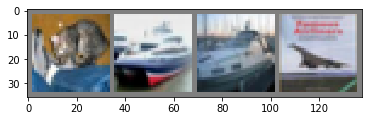

In [8]:
#在测试集上测试网络
dataiter = iter(testloader)
images,labels = dataiter.next()

#显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
#现在让我们看看神经网络会认为上面的例子是什么：
outputs = net(images)

In [10]:
#输出是10个标签的能量。 一个类别的能量越大，神经网络越认为它是这个类别。所以让我们得到最高能量的标签。
_,predicted = torch.max(outputs,1)
print('Predicted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   cat   car   car  ship


In [11]:
#看看网络在整个测试集上的结果
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images:%d %%'%
     (100 * correct / total))

Accuracy of the network on the 10000 test images:54 %


In [12]:
#表现良好的类，以及表现不佳的类
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (classes[i],
          100 * class_correct[i] / class_total[i]))

Accuracy of plane: 52 %
Accuracy of   car: 64 %
Accuracy of  bird: 20 %
Accuracy of   cat: 35 %
Accuracy of  deer: 40 %
Accuracy of   dog: 49 %
Accuracy of  frog: 69 %
Accuracy of horse: 75 %
Accuracy of  ship: 74 %
Accuracy of truck: 62 %


In [13]:
#在GPU上训练
# 首先把我们的设备定义为第一个可见的CUDA设备，如果我们有CUDA的话：
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
#假定设备是台CUDA设备
#递归遍历所有模块，并将它们的参数和缓冲器转换为CUDA张量
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
#每一个步骤向GPU发送输入和目标
inputs,labels = data[0].to(device),data[1].to(device)